In [ ]:
# Start writing code here...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import pickle
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import pprint

In [ ]:
def calculate_age(birthDate):
    #birthDate=str(birthDate)
    d,m,y = birthDate.split('-')
    if int(y) < 21: y='20'+y
    else: y= '19'+y
    b = date(int(y),int(m),int(d))
    today=date.today()
    return today.year - b.year - ((today.month, today.day) <(b.month, b.day))

def yrs_mon_to_month(s):
    sp=re.split('yrs|mon',s)
    return int(sp[0])*12 + int(sp[1])

def encode_description(X):
    '''

    '''
    X=X.drop('PERFORM_CNS.SCORE', axis=1) # drop PERFORM_CNS.SCORE
    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('No Bureau History Available', 
                                     'Not Scored: Sufficient History Not Available','Not Scored: Not Enough Info available on the customer',
                                     'Not Scored: No Activity seen on the customer (Inactive)', 
                                     'Not Scored: No Updates available in last 36 months', 'Not Scored: Only a Guarantor'),(0, 0, 0, 0, 0, 0))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('L-Very High Risk', 'M-Very High Risk', 
                                     'Not Scored: More than 50 active Accounts found'), (1, 1, 1))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('J-High Risk', 'K-High Risk'), (2, 2))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('H-Medium Risk', 'I-Medium Risk'), (3, 3))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('E-Low Risk', 'F-Low Risk', 'G-Low Risk'), (4, 4, 4))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('A-Very Low Risk', 'B-Very Low Risk',
                                      'C-Very Low Risk', 'D-Very Low Risk'), (5, 5, 5, 5))
    return X

def get_balance(df):
    # down sampling negative instances(nondefault), keep all the positive instances
    nondefault=df[df.loan_default==0].sample(n=df.loan_default.value_counts()[1], random_state=0)
    default=df[df.loan_default==1]
    df_balance= default.append(nondefault, ignore_index=True)
    df_balance=df_balance.sample(n=len(df_balance))
    return df_balance

In [ ]:
def preprocess(df):
    # transform birthDate to age
    df['Date.of.Birth']=df['Date.of.Birth'].apply(lambda x: calculate_age(x))
    df=df.rename(columns={'Date.of.Birth': 'Age'})

    # one hot encoding Employment.Type
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df=pd.DataFrame(enc.fit_transform(df[['Employment.Type']]).toarray())
    df=df.join(enc_df)
    df.columns = df.columns.astype(str) 
    df=df.rename(columns={'0': 'Salaried',
                       '1': 'Self_employed',
                       '2': 'Unknown_employ'})
    df=df.drop('Employment.Type',axis=1)

    # 
    df['AVERAGE.ACCT.AGE']=df['AVERAGE.ACCT.AGE'].apply(lambda s: yrs_mon_to_month(s))
    df['CREDIT.HISTORY.LENGTH']=df['CREDIT.HISTORY.LENGTH'].apply(lambda s: yrs_mon_to_month(s))

    # transform DisbursalDate to month
    df['DisbursalDate']=pd.to_datetime(df['DisbursalDate'],errors='coerce',dayfirst=True).dt.month
    df=df.rename(columns={'DisbursalDate': 'DisbursalMonth'})

    # encoding DisbursalMonth
    df=pd.get_dummies(df, columns=["DisbursalMonth"], prefix=["DisbursalMonth"])
    df['DisbursalMonth_8'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_9'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_10'] = df['DisbursalMonth_8'].astype(int)

    # encoding description
    df=encode_description(df)

    # drop some columns with ID (will try encoding later)
    id_col_to_drop=['UniqueID','Current_pincode_ID','supplier_id', 'Employee_code_ID']
    df=df.drop(columns=id_col_to_drop)

    # merge asset_cost and disbursed_amount
    df['Downpayment']=df['asset_cost']-df['disbursed_amount']
    df=df.drop(['asset_cost','disbursed_amount'],axis=1)

    drop_max=['PRI.NO.OF.ACCTS','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
    for d in drop_max:
        df= df.drop(index=df[df[d]== max(df[d])].index[0])

    drop_2max=['Downpayment','SEC.INSTAL.AMT']
    for d in drop_2max:
        df= df.drop(index=df[df[d]== max(df[d])].index[0])
        df= df.drop(index=df[df[d]== max(df[d])].index[0])

    # 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE' has negative values
    #print('Taking logrithmic')
    df['PRI.CURRENT.BALANCE']=df['PRI.CURRENT.BALANCE']-np.min(df['PRI.CURRENT.BALANCE'])
    df['SEC.CURRENT.BALANCE']=df['SEC.CURRENT.BALANCE']-np.min(df['SEC.CURRENT.BALANCE'])


    id_to_encode=['branch_id', 'manufacturer_id','State_ID']
    for i in id_to_encode:
        print('Encoding',i)
        df= pd.get_dummies(df, columns=[i], prefix=['{}'.format(i)])


    to_log_cols=['ltv','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS' , 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment','PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE']
    for c in to_log_cols:
        df[c]=np.log1p(df[c])
    #df=get_balance(df)
    return df

In [ ]:
train_raw=pd.read_csv('train_LTFS.csv')
train=train_raw.copy()
test_raw=pd.read_csv('test_LTFS.csv')

In [ ]:
train=preprocess(train)

Encoding branch_id
Encoding manufacturer_id
Encoding State_ID


In [ ]:
train=get_balance(train)

In [ ]:
train['loan_default'].value_counts()

1    50609
0    50609
Name: loan_default, dtype: int64

In [ ]:
# X = train.drop('loan_default',1) 
# # X=train[['ltv' ,'PERFORM_CNS.SCORE.DESCRIPTION', 'VoterID_flag' ,'NO.OF_INQUIRIES',
# #  'PRI.OVERDUE.ACCTS' ,'Salaried', 'PRI.ACTIVE.ACCTS' ,'Aadhar_flag',
# #  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' ,'PRI.NO.OF.ACCTS',
# #  'CREDIT.HISTORY.LENGTH' ,'AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS']]
# y = train.loan_default

# X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)

# print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
# oversample = SMOTE(random_state=1)
# X_train, y_train =oversample.fit_resample(X_train, y_train.ravel())
# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 35642
Before OverSampling, counts of label '0': 127560 

After OverSampling, counts of label '1': 127560
After OverSampling, counts of label '0': 127560


In [ ]:
y_train['loan_default'].value_counts()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# cc=['ltv','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
#        'PRI.OVERDUE.ACCTS' , 'PRI.SANCTIONED.AMOUNT',
#        'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
#        'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT',
#        'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
#        'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
#        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment','PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE']
# scaler = preprocessing.Normalizer().fit(X_train.loc[:,cc])
# X_train.loc[:,cc]=scaler.transform(X_train.loc[:,cc])
# X_vali.loc[:,cc]=scaler.transform(X_vali.loc[:,cc])

In [ ]:
#GridSearch code. Returns best_params_ and best_socre_
def model_perf(model,params,scoring,refit_val,X,y):
    grid_search = GridSearchCV(estimator=model,param_grid=params,scoring=scoring,return_train_score=True,refit=refit_val,verbose=1,n_jobs=-1)
    gs_val = grid_search.fit(X,y)
    return gs_val.best_params_, gs_val.best_score_

from sklearn.model_selection import GridSearchCV

In [ ]:
# rand_prams= [{'n_estimators':[100,200,450,650,850],'max_depth':[5,7,10],'criterion':['gini','entropy']}]
# best_params, best_score=model_perf(RandomForestClassifier(),rand_prams,['precision','recall'],'precision',X_train,y_train)# using a custom fucnction that has code for GridSearchCV

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
X = train.drop('loan_default',1) 
y = train.loan_default
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)

In [ ]:
#modelRF = RandomForestClassifier(n_estimators=300,random_state=0,n_jobs=-1,verbose=1)
modelRF = RandomForestClassifier(n_estimators=300,random_state=0,n_jobs=-1,verbose=1)
modelRF.fit(X_train, y_train)

predRF = modelRF.predict(X_vali)

print("Train Accuracy: ", modelRF.score(X_train, y_train))
print("Validation Accuracy: ", modelRF.score(X_vali, y_vali))

#print("AUROC Score of Random Forest = ", roc_auc_score(Y_valid, Y_predRF))

#save model
# f = open('saved_RF_id_encoding_300tree2_smote_drop2','wb')
# pickle.dump(modelRF,f)
# f.close()
# print('--------Model saved---------')

confusion = metrics.confusion_matrix(y_vali, predRF)
print('----confusion matrix----')
print(confusion)
print('Accuracy_Score:', metrics.accuracy_score(y_vali, predRF))
# print('Sensitivity or Recall:', metrics.recall_score(y_vali, y_vali_pred))
print(classification_report(y_vali, predRF))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
Train Accuracy:  0.999675379664653
[Par

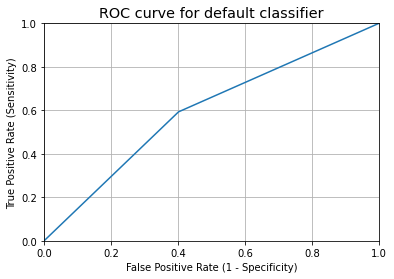

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_vali,predRF)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for default classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
# using RandomizedSearchCV tuning hyperparameter in Randomforest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                                param_distributions = random_grid, 
                                n_iter = 5,
                                cv = 3, 
                                verbose=1, 
                                random_state=1, 
                                n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print('Best parameters:', rf_random.best_params_)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}


In [ ]:
b_rf=rf_random.best_estimator_
b_pred = b_rf.predict(X_vali)
print(classification_report(y_vali, b_pred))

              precision    recall  f1-score   support

           0       0.62      0.57      0.59     15145
           1       0.60      0.65      0.62     15221

    accuracy                           0.61     30366
   macro avg       0.61      0.61      0.61     30366
weighted avg       0.61      0.61      0.61     30366



In [ ]:

modelGB= GradientBoostingClassifier(n_estimators=200, learning_rate=0.4, random_state=0, verbose=1)
modelGB.fit(X_train, y_train)
predGB = modelGB.predict(X_vali)

print("Train Accuracy: ", modelGB.score(X_train, y_train))
print("Validation Accuracy: ", modelGB.score(X_vali, y_vali))

#print("AUROC Score of Random Forest = ", roc_auc_score(Y_valid, Y_predRF))

#save model
# f = open('saved_RF_id_encoding_300tree2_smote_drop2','wb')
# pickle.dump(modelRF,f)
# f.close()
# print('--------Model saved---------')

confusion = metrics.confusion_matrix(y_vali, predGB)
print('----confusion matrix----')
print(confusion)
print('Accuracy_Score:', metrics.accuracy_score(y_vali, predGB))
# print('Sensitivity or Recall:', metrics.recall_score(y_vali, y_vali_pred))
print(classification_report(y_vali, predGB))

      Iter       Train Loss   Remaining Time 
         1           1.3798           44.26s
         2           1.3744           43.01s
         3           1.3699           43.60s
         4           1.3662           44.17s
         5           1.3627           43.41s
         6           1.3599           42.70s
         7           1.3573           42.29s
         8           1.3548           41.83s
         9           1.3527           41.41s
        10           1.3507           41.06s
        20           1.3366           37.99s
        30           1.3281           35.52s
        40           1.3223           33.13s
        50           1.3178           30.90s
        60           1.3141           28.84s
        70           1.3111           26.60s
        80           1.3085           24.46s
        90           1.3062           22.33s
       100           1.3043           20.25s
       200           1.2900            0.00s
Train Accuracy:  0.6267148422062891
Validation Accurac

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85463a1c-f246-4a97-953d-d1ccc73b61e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>